<a href="https://colab.research.google.com/github/Tilakraj-B/cardiac-disease/blob/main/Project(6)_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import math
from google.colab import drive
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt
from skimage.morphology import binary_erosion
from scipy.ndimage import distance_transform_edt as distance_transform
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, mean_absolute_error


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/acdc_dataset.zip"  # Update this path
extract_folder = "/content/acdc_data"

In [13]:
# Step 3: Extract the dataset if not already extracted
if not os.path.exists(extract_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")


Extracting dataset...
Extraction complete.


In [14]:
def extract_cfg_values(file_path):
    config = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):  # Ignore empty lines and comments
                    if ':' in line:
                        key, value = line.split(':', 1)
                        config[key.strip()] = value.strip()
                    elif '=' in line:
                        key, value = line.split('=', 1)
                        config[key.strip()] = value.strip()
        return config
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

In [15]:
def load_nii_file(file_path):
    """Load NIFTI file and return data + voxel dimensions"""
    img = nib.load(file_path)
    data = img.get_fdata()
    pixdims = img.header.get_zooms()
    return data, pixdims


In [16]:
# Step 5: Load and visualize a sample image (Modify the path based on extracted files)
base_dir = os.path.join(extract_folder,"database")
training_folder = os.path.join(extract_folder,"database","training")
testing_folder = os.path.join(extract_folder,"database","testing")
train_patients = [f'patient{i:03d}' for i in range(1, 100)]
test_patients = [f'patient{i:03d}' for i in range(1, 50)]

In [17]:
# Display all the images of a patient

def display_nifti_slices(nifti_path):
    nifti_img = nib.load(nifti_path)  # Load NIfTI file
    image_data = nifti_img.get_fdata()  # Convert to NumPy array

    print(f"\nDisplaying slices for {os.path.basename(nifti_path)}")
    print(f"Image shape: {image_data.shape}")  # Print shape

    dim = image_data.ndim  # Get number of dimensions
    if dim == 2:  # Case: 2D Image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_data, cmap="gray")
        plt.title(f"{os.path.basename(nifti_path)} - 2D Image")
        plt.axis("off")
        plt.show()

    elif dim == 3:  # Case: 3D Image (H, W, D)
        num_slices = image_data.shape[2]
        for i in range(num_slices):
            plt.figure(figsize=(6, 6))
            plt.imshow(image_data[:, :, i], cmap="gray")
            plt.title(f"{os.path.basename(nifti_path)} - Slice {i+1}/{num_slices}")
            plt.axis("off")
            plt.show()

    elif dim == 4:  # Case: 4D Image (H, W, D, T)
        num_slices = image_data.shape[2]
        num_timeframes = image_data.shape[3]
        for t in range(num_timeframes):  # Loop over time
            for i in range(num_slices):  # Loop over depth
                plt.figure(figsize=(6, 6))
                plt.imshow(image_data[:, :, i, t], cmap="gray")
                plt.title(f"{os.path.basename(nifti_path)} - Time {t+1}/{num_timeframes} - Slice {i+1}/{num_slices}")
                plt.axis("off")
                plt.show()

    else:
        print(f"Unsupported image dimension: {dim}")

In [18]:
def extract_roi_adaptive(image, mask, margin_ratio=0.2):
    coords = np.where(mask > 0)
    if not coords[0].any():
        return image, mask

    y_min, y_max = np.min(coords[0]), np.max(coords[0])
    x_min, x_max = np.min(coords[1]), np.max(coords[1])

    # Dynamic margin (e.g., 20% of object height/width)
    h, w = y_max - y_min, x_max - x_min
    margin_y = int(h * margin_ratio)
    margin_x = int(w * margin_ratio)

    y_min = max(y_min - margin_y, 0)
    y_max = min(y_max + margin_y, image.shape[0] - 1)
    x_min = max(x_min - margin_x, 0)
    x_max = min(x_max + margin_x, image.shape[1] - 1)

    return image[y_min:y_max+1, x_min:x_max+1], mask[y_min:y_max+1, x_min:x_max+1]

In [19]:
def resize_with_padding(image, mask, target_size=(80, 80)):
    # Resize image (use linear interpolation)
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized_img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    resized_mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)  # Critical for masks

    # Pad to target size
    pad_img = np.zeros((target_size[0], target_size[1]), dtype=image.dtype)
    pad_mask = np.zeros((target_size[0], target_size[1]), dtype=mask.dtype)

    y_offset = (target_size[0] - new_h) // 2
    x_offset = (target_size[1] - new_w) // 2

    pad_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img
    pad_mask[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_mask

    return pad_img, pad_mask

In [20]:
def calculate_volume(nifti_file_path, original_image_mask):
    """Calculates the volume of segmented regions from the mask."""
    nifti_image = nib.load(nifti_file_path)
    header = nifti_image.header
    voxel_spacing = header['pixdim']
    spacing_x = voxel_spacing[1]
    spacing_y = voxel_spacing[2]
    spacing_z = voxel_spacing[3]
    voxel_volume = spacing_x * spacing_y * spacing_z
    volumes = {}
    unique_labels = np.unique(original_image_mask)
    for label in unique_labels:
        if label > 0:
            num_voxels = np.sum(original_image_mask == label)
            volume_label = num_voxels * voxel_volume
            volumes[label] = volume_label/1000
    return volumes


In [21]:
def calculate_class_volumes2D(nii_file_path, stacked_mask):
    # Load NIfTI header for voxel dimensions
    img = nib.load(nii_file_path)
    header = img.header
    pixdims = header['pixdim']
    pixel_spacing_x = pixdims[1]
    pixel_spacing_y = pixdims[2]
    slice_thickness = pixdims[3]

    voxel_volume = pixel_spacing_x * pixel_spacing_y * slice_thickness
    volumes = [0, 0, 0, 0]  # Indexes 0 (background) is unused

    for j in range(len(stacked_mask)):
        slice_mask = stacked_mask[j]

        # Check if the mask is 4-channel (one-hot encoded)
        if slice_mask.ndim == 3 and slice_mask.shape[2] == 4:
            # Convert to single-channel label mask (0-3)
            label_mask = np.argmax(slice_mask, axis=-1)
        else:
            # Assume it's already a single-channel label mask
            label_mask = slice_mask

        for label in range(1, 4):  # Labels 1, 2, 3
            num_voxels = np.sum(label_mask == label)
            volume_label = num_voxels * voxel_volume
            volumes[label] += volume_label / 1000  # Convert mm³ to mL

    return volumes

In [22]:
def load_patient_data(patient_folder, es_or_ed):
    # Get all .nii files in the folder
    info = extract_cfg_values(os.path.join(patient_folder, "Info.cfg"))
    es = info.get('ES').zfill(2)
    ed = info.get('ED').zfill(2)
    if es_or_ed == 'ES':
      files = [f for f in os.listdir(patient_folder) if f.endswith(es + '.nii') or f.endswith(es + '_gt.nii')]
    elif es_or_ed == 'ED':
      files = [f for f in os.listdir(patient_folder) if f.endswith(ed + '.nii') or f.endswith(ed + '_gt.nii')]
    else :
      files = [f for f in os.listdir(patient_folder) if f.endswith(ed + '.nii') or f.endswith(ed + '_gt.nii') or f.endswith(es + '.nii') or f.endswith(es + '_gt.nii')]

    # Separate image and ground truth files
    image_files = [f for f in files if not f.endswith('_gt.nii')]
    gt_files = [f for f in files if f.endswith('_gt.nii')]
    # print(patient_folder)
    # print(sorted(image_files))
    # print(sorted(gt_files))
    images = []
    masks = []
    roi_images = []
    roi_masks = []
    temp_roi = []
    volume_info = []  # To store voxel dimensions for each volume


    for img_file, gt_file in zip(sorted(image_files), sorted(gt_files)):
        temp_roi = []
        img_data, img_pixdims = load_nii_file(os.path.join(patient_folder, img_file))
        gt_data, gt_pixdims = load_nii_file(os.path.join(patient_folder, gt_file))
        volume_info.append({
            'pixdims': gt_pixdims,
            'original_shape': gt_data.shape
        })
        # print(img_file)
        # print(gt_file)
        # print(" ")
        # volumes = calculate_volume(os.path.join(patient_folder, gt_file), gt_data)
        # print(volumes);
        # iterating through each slice in the model
        for slice_idx in range(img_data.shape[2]):
            img_slice = img_data[..., slice_idx]
            gt_slice = gt_data[..., slice_idx]

            # Normalize and resize if needed
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())

            # ROI Extraction Step
            img_slice, gt_slice = extract_roi_adaptive(img_slice, gt_slice)
            roi_images.append(img_slice)
            roi_masks.append(gt_slice)
            temp_roi.append(gt_slice)

            # Resize to make dimensions divisible by 16 for U-Net (optional)
            img_slice, gt_slice = resize_with_padding(img_slice, gt_slice)

            gt_slice_np = gt_slice.astype(np.uint8)   # shape (256,256), values 0/1/2
            unique_labels = np.unique(gt_slice_np)

            gt_slice_cat = tf.keras.utils.to_categorical(gt_slice_np, num_classes=4)  # shape (256,256,4)

            images.append(img_slice)
            masks.append(gt_slice_cat)

        # volume = calculate_class_volumes2D(os.path.join(patient_folder, gt_file),temp_roi)
        # print(volume);
        # print('hi')
        # print('hello')

    return  np.array(images), np.array(masks), roi_images, roi_masks, volume_info




In [23]:
def load_dataset(root_folder, patient_range):
    all_images = []
    all_masks = []
    inah = [0,0,0,0]
    inaw = [0,0,0,0]
    for patient_id in patient_range:
        patient_folder = os.path.join(root_folder, f"patient{patient_id:03d}")
        if os.path.exists(patient_folder):
            images, masks, _, _,_= load_patient_data(patient_folder , 'EDES')
            all_images.extend(images)
            all_masks.extend(masks)
            # for j in range(0,4):
            #   inah[j] += inh[j]
            #   inaw[j] += inw[j]
        else:
            print(f"Patient folder not found: {patient_folder}")
    # for j in range(0,4):
    #   print("ina",j,inah[j])
    #   print("ina",j,inaw[j])

    return np.array(all_images), np.array(all_masks)


In [ ]:
# load_dataset(testing_folder, range(101, 151))

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

def unet(input_size=(80, 80, 1)):
    inputs = Input(input_size)

    # Encoder Level 1
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Encoder Level 2
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Encoder Level 3
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom (now deeper)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.3)(conv4)

    # Decoder Level 1
    up5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(drop4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    # Decoder Level 2
    up6 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    # Decoder Level 3
    up7 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # Output
    outputs = Conv2D(4, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [25]:
def dice_coef_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')  # 💡 make sure both are float32
    y_pred = K.cast(y_pred, 'float32')

    dice = 0
    for c in range(y_true.shape[-1]):
        y_t = y_true[..., c]
        y_p = y_pred[..., c]
        inter = K.sum(y_t * y_p)
        union = K.sum(y_t) + K.sum(y_p)
        dice += (2. * inter + smooth) / (union + smooth)

    return dice / y_true.shape[-1]  # mean over all classes

tf.keras.utils.get_custom_objects().update({'dice_coef_multiclass': dice_coef_multiclass})


In [26]:
def cosine_annealing(epoch, lr):
    """
    Cosine annealing from max_lr down to min_lr over total_epochs.
    """
    max_lr = 1e-3
    min_lr = 1e-4
    total_epochs = 100  # match your training epochs

    # compute new learning rate
    cos_inner = (math.pi * (epoch % total_epochs)) / total_epochs
    new_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(cos_inner))
    return new_lr


In [6]:
def categorical_dice_loss(y_true, y_pred):
    return 1.0 - dice_coef_multiclass(y_true, y_pred)


In [33]:
def train_model():
    # Load training data
    train_images, train_masks = load_dataset(training_folder, range(1, 101))



    # Split into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_images, train_masks, test_size=0.2, random_state=42
    )


    # Create model
    model = unet()
    model.compile(
    optimizer=tf.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss=categorical_dice_loss,
    metrics=['accuracy', dice_coef_multiclass]
)

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=25, monitor='val_loss',restore_best_weights=True),
        LearningRateScheduler(cosine_annealing, verbose=1)
    ]

    # Train
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=8,
        epochs=100,
        callbacks=callbacks
    )

    return model, history

In [27]:
def dice_coefficient(y_true, y_pred, class_idx):
    intersection = np.sum((y_true == class_idx) & (y_pred == class_idx))
    sum_pixels = np.sum(y_true == class_idx) + np.sum(y_pred == class_idx)
    return (2. * intersection) / (sum_pixels + 1e-6)

def hausdorff_distance(y_true, y_pred, class_idx):
    true_mask = (y_true == class_idx)
    pred_mask = (y_pred == class_idx)

    true_pts = np.argwhere(true_mask)
    pred_pts = np.argwhere(pred_mask)

    if len(true_pts) == 0 or len(pred_pts) == 0:
        return np.nan

    forward_hd = directed_hausdorff(true_pts, pred_pts)[0]
    backward_hd = directed_hausdorff(pred_pts, true_pts)[0]
    return max(forward_hd, backward_hd)

def average_surface_distance(y_true, y_pred, class_idx):
    true_mask = (y_true == class_idx)
    pred_mask = (y_pred == class_idx)

    if not np.any(true_mask) or not np.any(pred_mask):
        return np.nan

    true_dist = distance_transform_edt(~true_mask)
    pred_dist = distance_transform_edt(~pred_mask)

    surface_true = np.logical_xor(true_mask, np.logical_and(true_mask, pred_mask))
    surface_pred = np.logical_xor(pred_mask, np.logical_and(true_mask, pred_mask))

    dist1 = true_dist[surface_pred]
    dist2 = pred_dist[surface_true]

    return (np.mean(dist1) + np.mean(dist2)) / 2

def calculate_metrics(y_true, y_pred, num_classes=4):
    y_true_flat = np.argmax(y_true, axis=-1).flatten()
    y_pred_flat = y_pred.flatten()

    print("Classification Report:")
    print(classification_report(y_true_flat, y_pred_flat))

    cm = confusion_matrix(y_true_flat, y_pred_flat)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    for i in range(num_classes):
        print(f"\nClass {i}:")
        iou = jaccard_score((y_true_flat == i), (y_pred_flat == i))
        dice = dice_coefficient(y_true_flat, y_pred_flat, i)
        # hd = hausdorff_distance(y_true_flat, y_pred_flat, i)
        asd = average_surface_distance(y_true_flat, y_pred_flat, i)

        pred_volume = np.sum(y_pred_flat == i)
        true_volume = np.sum(y_true_flat == i)
        intersection = np.sum((y_true_flat == i) & (y_pred_flat == i))
        union = pred_volume + true_volume - intersection

        voe = 100 * (1 - intersection / (union + 1e-6))
        vs = 1 - abs(pred_volume - true_volume) / (pred_volume + true_volume + 1e-6)

        print(f"IoU         = {iou:.4f}")
        print(f"Dice        = {dice:.4f}")
        # print(f"Hausdorff   = {hd:.4f}")
        print(f"ASD         = {asd:.4f}")
        print(f"VOE (%)     = {voe:.2f}")
        print(f"Volume Sim. = {vs:.4f}")

def evaluate_model(model):
    test_images, test_masks = load_dataset(testing_folder, range(101, 151))

    results = model.evaluate(test_images, test_masks)
    print(f"\nTest Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}\n")

    predicted_probs = model.predict(test_images)
    predicted_masks = np.argmax(predicted_probs, axis=-1)
    true_masks = np.argmax(test_masks, axis=-1)

    calculate_metrics(test_masks, predicted_masks)

    plt.figure(figsize=(20, 10))
    for i in range(10):
        original_image = test_images[i].squeeze()
        true_mask = true_masks[i]
        pred_mask = predicted_masks[i]

        plt.subplot(3, 10, i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Input')
        plt.axis('off')

        plt.subplot(3, 10, i + 11)
        plt.imshow(true_mask, cmap='jet')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(3, 10, i + 21)
        plt.imshow(pred_mask, cmap='jet')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [10]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6918 - dice_coef_multiclass: 0.5223 - loss: 0.4777

191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.6924 - dice_coef_multiclass: 0.5231 - loss: 0.4769 - val_accuracy: 0.8910 - val_dice_coef_multiclass: 0.8107 - val_loss: 0.1891 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009997779521645793.
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8954 - dice_coef_multiclass: 0.8208 - loss: 0.1792

191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8955 - dice_coef_multiclass: 0.8209 - loss: 0.1791 - val_accuracy: 0.9112 - val_dice_coef_multiclass: 0.8629 - val_loss: 0.1371 - learning_rate: 9.9978e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009991120277927223.
Epoch 3/100
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9194 - dice_coef_multiclass: 0.8648 - loss: 0.1352

191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9195 - dice_coef_multiclass: 0.8650 - loss: 0.1350 - val_accuracy: 0.9375 - val_dice_coef_multiclass: 0.8954 - val_loss: 0.1046 - learning_rate: 9.9911e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000998002884071386.
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9368 - dice_coef_multiclass: 0.8935 - loss: 0.1065 - val_accuracy: 0.9258 - val_dice_coef_multiclass: 0.8721 - val_loss: 0.1280 - learning_rate: 9.9800e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000996451615591515.
Epoch 5/100
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9381 - dice_coef_multiclass: 0.8937 - loss: 0.1063

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9383 - dice_coef_multiclass: 0.8940 - loss: 0.1060 - val_accuracy: 0.9497 - val_dice_coef_multiclass: 0.9157 - val_loss: 0.0842 - learning_rate: 9.9645e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.000994459753267812.
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9497 - dice_coef_multiclass: 0.9156 - loss: 0.0844 - val_accuracy: 0.9490 - val_dice_coef_multiclass: 0.9126 - val_loss: 0.0874 - learning_rate: 9.9446e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.00099202926282791.
Epoch 7/100
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9488 - dice_coef_multiclass: 0.9120 - loss: 0.0880

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9488 - dice_coef_multiclass: 0.9121 - loss: 0.0878 - val_accuracy: 0.9516 - val_dice_coef_multiclass: 0.9189 - val_loss: 0.0810 - learning_rate: 9.9203e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0009891625428724363.
Epoch 8/100
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9501 - dice_coef_multiclass: 0.9149 - loss: 0.0851

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9501 - dice_coef_multiclass: 0.9150 - loss: 0.0850 - val_accuracy: 0.9536 - val_dice_coef_multiclass: 0.9220 - val_loss: 0.0778 - learning_rate: 9.8916e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.000985862422507884.
Epoch 9/100
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9555 - dice_coef_multiclass: 0.9251 - loss: 0.0749

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9555 - dice_coef_multiclass: 0.9250 - loss: 0.0749 - val_accuracy: 0.9564 - val_dice_coef_multiclass: 0.9273 - val_loss: 0.0727 - learning_rate: 9.8586e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0009821321585546244.
Epoch 10/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9590 - dice_coef_multiclass: 0.9304 - loss: 0.0696 - val_accuracy: 0.9555 - val_dice_coef_multiclass: 0.9262 - val_loss: 0.0737 - learning_rate: 9.8213e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0009779754323328191.
Epoch 11/100
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9585 - dice_coef_multiclass: 0.9310 - loss: 0.0690

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9585 - dice_coef_multiclass: 0.9310 - loss: 0.0690 - val_accuracy: 0.9574 - val_dice_coef_multiclass: 0.9291 - val_loss: 0.0708 - learning_rate: 9.7798e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0009733963460294015.
Epoch 12/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9584 - dice_coef_multiclass: 0.9301 - loss: 0.0699 - val_accuracy: 0.9546 - val_dice_coef_multiclass: 0.9255 - val_loss: 0.0744 - learning_rate: 9.7340e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0009683994186497131.
Epoch 13/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9587 - dice_coef_multiclass: 0.9311 - loss: 0.0689 - val_accuracy: 0.9559 - val_dice_coef_multiclass: 0.9270 - val_loss: 0.0729 - learning_rate: 9.6840e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0009629895815577914.
Epoch 14/100
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9621 - dice_coef_multiclass

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9621 - dice_coef_multiclass: 0.9364 - loss: 0.0636 - val_accuracy: 0.9596 - val_dice_coef_multiclass: 0.9324 - val_loss: 0.0675 - learning_rate: 9.6299e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0009571721736097088.
Epoch 15/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9644 - dice_coef_multiclass: 0.9406 - loss: 0.0594 - val_accuracy: 0.9587 - val_dice_coef_multiclass: 0.9314 - val_loss: 0.0685 - learning_rate: 9.5717e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0009509529358847655.
Epoch 16/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9629 - dice_coef_multiclass: 0.9391 - loss: 0.0609 - val_accuracy: 0.9577 - val_dice_coef_multiclass: 0.9305 - val_loss: 0.0695 - learning_rate: 9.5095e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0009443380060197386.
Epoch 17/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9644 - dice_coef_multiclas

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9661 - dice_coef_multiclass: 0.9437 - loss: 0.0563 - val_accuracy: 0.9594 - val_dice_coef_multiclass: 0.9324 - val_loss: 0.0675 - learning_rate: 9.2219e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009140576474687263.
Epoch 21/100
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9664 - dice_coef_multiclass: 0.9447 - loss: 0.0553

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9664 - dice_coef_multiclass: 0.9447 - loss: 0.0553 - val_accuracy: 0.9597 - val_dice_coef_multiclass: 0.9336 - val_loss: 0.0663 - learning_rate: 9.1406e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009055697555690606.
Epoch 22/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9680 - dice_coef_multiclass: 0.9476 - loss: 0.0523 - val_accuracy: 0.9587 - val_dice_coef_multiclass: 0.9309 - val_loss: 0.0690 - learning_rate: 9.0557e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0008967309592491052.
Epoch 23/100
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9657 - dice_coef_multiclass: 0.9440 - loss: 0.0560

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9657 - dice_coef_multiclass: 0.9440 - loss: 0.0560 - val_accuracy: 0.9612 - val_dice_coef_multiclass: 0.9353 - val_loss: 0.0646 - learning_rate: 8.9673e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0008875499813337069.
Epoch 24/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9678 - dice_coef_multiclass: 0.9467 - loss: 0.0533 - val_accuracy: 0.9580 - val_dice_coef_multiclass: 0.9305 - val_loss: 0.0694 - learning_rate: 8.8755e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0008780358823396353.
Epoch 25/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9656 - dice_coef_multiclass: 0.9421 - loss: 0.0579 - val_accuracy: 0.9587 - val_dice_coef_multiclass: 0.9319 - val_loss: 0.0681 - learning_rate: 8.7804e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0008681980515339464.
Epoch 26/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9661 - dice_coef_multiclas

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9696 - dice_coef_multiclass: 0.9501 - loss: 0.0499 - val_accuracy: 0.9613 - val_dice_coef_multiclass: 0.9356 - val_loss: 0.0643 - learning_rate: 7.9112e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0007790686370876671.
Epoch 34/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9700 - dice_coef_multiclass: 0.9495 - loss: 0.0505

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9700 - dice_coef_multiclass: 0.9495 - loss: 0.0505 - val_accuracy: 0.9611 - val_dice_coef_multiclass: 0.9357 - val_loss: 0.0642 - learning_rate: 7.7907e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0007667891533457719.
Epoch 35/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9704 - dice_coef_multiclass: 0.9513 - loss: 0.0487 - val_accuracy: 0.9598 - val_dice_coef_multiclass: 0.9338 - val_loss: 0.0662 - learning_rate: 7.6679e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.000754295724882796.
Epoch 36/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9713 - dice_coef_multiclass: 0.9528 - loss: 0.0472 - val_accuracy: 0.9608 - val_dice_coef_multiclass: 0.9348 - val_loss: 0.0652 - learning_rate: 7.5430e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0007416006812042827.
Epoch 37/100
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9710 - dice_coef_multiclass:

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9710 - dice_coef_multiclass: 0.9527 - loss: 0.0473 - val_accuracy: 0.9612 - val_dice_coef_multiclass: 0.9364 - val_loss: 0.0635 - learning_rate: 7.4160e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0007287165507856513.
Epoch 38/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9715 - dice_coef_multiclass: 0.9532 - loss: 0.0468 - val_accuracy: 0.9608 - val_dice_coef_multiclass: 0.9361 - val_loss: 0.0639 - learning_rate: 7.2872e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0007156560487081052.
Epoch 39/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9660 - dice_coef_multiclass: 0.9432 - loss: 0.0568 - val_accuracy: 0.9609 - val_dice_coef_multiclass: 0.9350 - val_loss: 0.0649 - learning_rate: 7.1566e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0007024320641103813.
Epoch 40/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9706 - dice_coef_multiclas

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9724 - dice_coef_multiclass: 0.9545 - loss: 0.0455 - val_accuracy: 0.9620 - val_dice_coef_multiclass: 0.9375 - val_loss: 0.0624 - learning_rate: 6.4816e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0006343215915635762.
Epoch 45/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9720 - dice_coef_multiclass: 0.9545 - loss: 0.0455 - val_accuracy: 0.9609 - val_dice_coef_multiclass: 0.9353 - val_loss: 0.0646 - learning_rate: 6.3432e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.000620395509268104.
Epoch 46/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9729 - dice_coef_multiclass: 0.9551 - loss: 0.0449 - val_accuracy: 0.9604 - val_dice_coef_multiclass: 0.9353 - val_loss: 0.0647 - learning_rate: 6.2040e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.000606399955103937.
Epoch 47/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9730 - dice_coef_multiclass:

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9760 - dice_coef_multiclass: 0.9600 - loss: 0.0400 - val_accuracy: 0.9622 - val_dice_coef_multiclass: 0.9376 - val_loss: 0.0623 - learning_rate: 3.5840e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.00034570427511720393.
Epoch 66/100
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9763 - dice_coef_multiclass: 0.9614 - loss: 0.0386

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9763 - dice_coef_multiclass: 0.9614 - loss: 0.0386 - val_accuracy: 0.9622 - val_dice_coef_multiclass: 0.9378 - val_loss: 0.0621 - learning_rate: 3.4570e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0003332108466542281.
Epoch 67/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9763 - dice_coef_multiclass: 0.9613 - loss: 0.0387 - val_accuracy: 0.9623 - val_dice_coef_multiclass: 0.9377 - val_loss: 0.0623 - learning_rate: 3.3321e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.0003209313629123329.
Epoch 68/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9771 - dice_coef_multiclass: 0.9620 - loss: 0.0380

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9771 - dice_coef_multiclass: 0.9620 - loss: 0.0380 - val_accuracy: 0.9622 - val_dice_coef_multiclass: 0.9381 - val_loss: 0.0618 - learning_rate: 3.2093e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.0003088779422594514.
Epoch 69/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9773 - dice_coef_multiclass: 0.9622 - loss: 0.0378 - val_accuracy: 0.9620 - val_dice_coef_multiclass: 0.9373 - val_loss: 0.0626 - learning_rate: 3.0888e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.0002970624799665412.
Epoch 70/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9768 - dice_coef_multiclass: 0.9618 - loss: 0.0382 - val_accuracy: 0.9625 - val_dice_coef_multiclass: 0.9379 - val_loss: 0.0621 - learning_rate: 2.9706e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.00028549663646838715.
Epoch 71/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9767 - dice_coef_multicla

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9805 - dice_coef_multiclass: 0.9673 - loss: 0.0327 - val_accuracy: 0.9627 - val_dice_coef_multiclass: 0.9385 - val_loss: 0.0614 - learning_rate: 1.1787e-04

Epoch 93: LearningRateScheduler setting learning rate to 0.00011413757749211607.
Epoch 93/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9802 - dice_coef_multiclass: 0.9674 - loss: 0.0326 - val_accuracy: 0.9626 - val_dice_coef_multiclass: 0.9382 - val_loss: 0.0618 - learning_rate: 1.1414e-04

Epoch 94: LearningRateScheduler setting learning rate to 0.0001108374571275637.
Epoch 94/100
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9804 - dice_coef_multiclass: 0.9677 - loss: 0.0323

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9804 - dice_coef_multiclass: 0.9677 - loss: 0.0323 - val_accuracy: 0.9628 - val_dice_coef_multiclass: 0.9387 - val_loss: 0.0613 - learning_rate: 1.1084e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.00010797073717209008.
Epoch 95/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9805 - dice_coef_multiclass: 0.9676 - loss: 0.0324 - val_accuracy: 0.9627 - val_dice_coef_multiclass: 0.9385 - val_loss: 0.0615 - learning_rate: 1.0797e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.00010554024673218806.
Epoch 96/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9803 - dice_coef_multiclass: 0.9676 - loss: 0.0324 - val_accuracy: 0.9627 - val_dice_coef_multiclass: 0.9384 - val_loss: 0.0615 - learning_rate: 1.0554e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.00010354838440848502.
Epoch 97/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9802 - dice_coef_multic

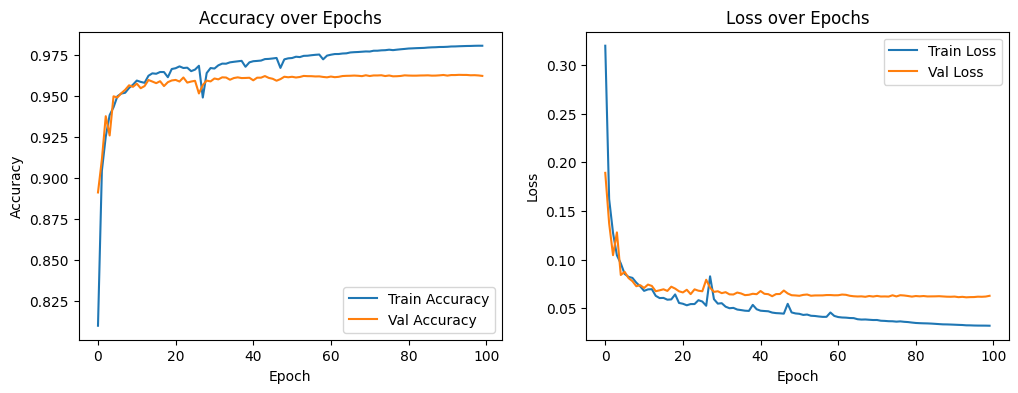

In [34]:
import json

if not os.path.exists('unet_mri_segmentation.keras'):
    model, history = train_model()

    # Save model
    model.save('unet_mri_segmentation.keras')

    # Save training history
    with open('training_history.json', 'w') as f:
        json.dump(history.history, f)

    plot_training_history(history)
else:
    model = tf.keras.models.load_model('unet_mri_segmentation.keras')

    # Load training history if needed
    if os.path.exists('training_history.json'):
        with open('training_history.json', 'r') as f:
            history_data = json.load(f)

        # Create a dummy History object if needed
        class DummyHistory:
            def __init__(self, history_dict):
                self.history = history_dict

        history = DummyHistory(history_data)
        plot_training_history(history)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9629 - dice_coef_multiclass: 0.9322 - loss: 0.0678

Test Loss: 0.0701, Test Accuracy: 0.9624

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98   4769291
           1       0.93      0.90      0.92    651418
           2       0.86      0.91      0.89    803829
           3       0.95      0.93      0.94    661862

    accuracy                           0.96   6886400
   macro avg       0.93      0.93      0.93   6886400
weighted avg       0.96      0.96      0.96   6886400



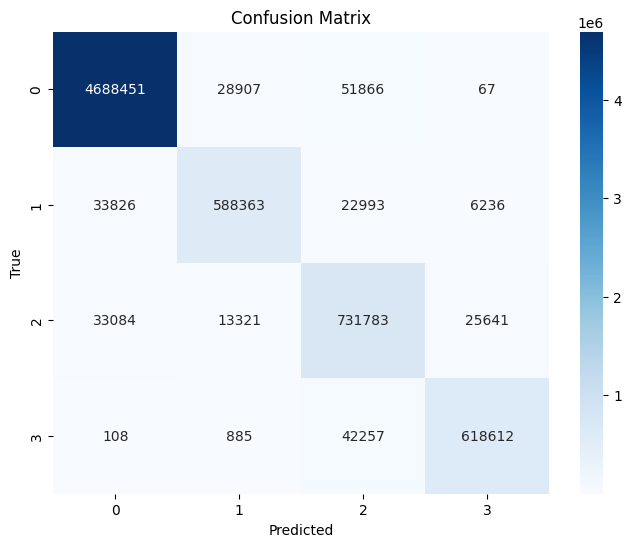


Class 0:
IoU         = 0.9694
Dice        = 0.9845
ASD         = 10.6768
VOE (%)     = 3.06
Volume Sim. = 0.9985

Class 1:
IoU         = 0.8471
Dice        = 0.9172
ASD         = 670.6614
VOE (%)     = 15.29
Volume Sim. = 0.9845

Class 2:
IoU         = 0.7946
Dice        = 0.8855
ASD         = 343.1744
VOE (%)     = 20.54
Volume Sim. = 0.9727

Class 3:
IoU         = 0.8916
Dice        = 0.9427
ASD         = 562.1531
VOE (%)     = 10.84
Volume Sim. = 0.9914


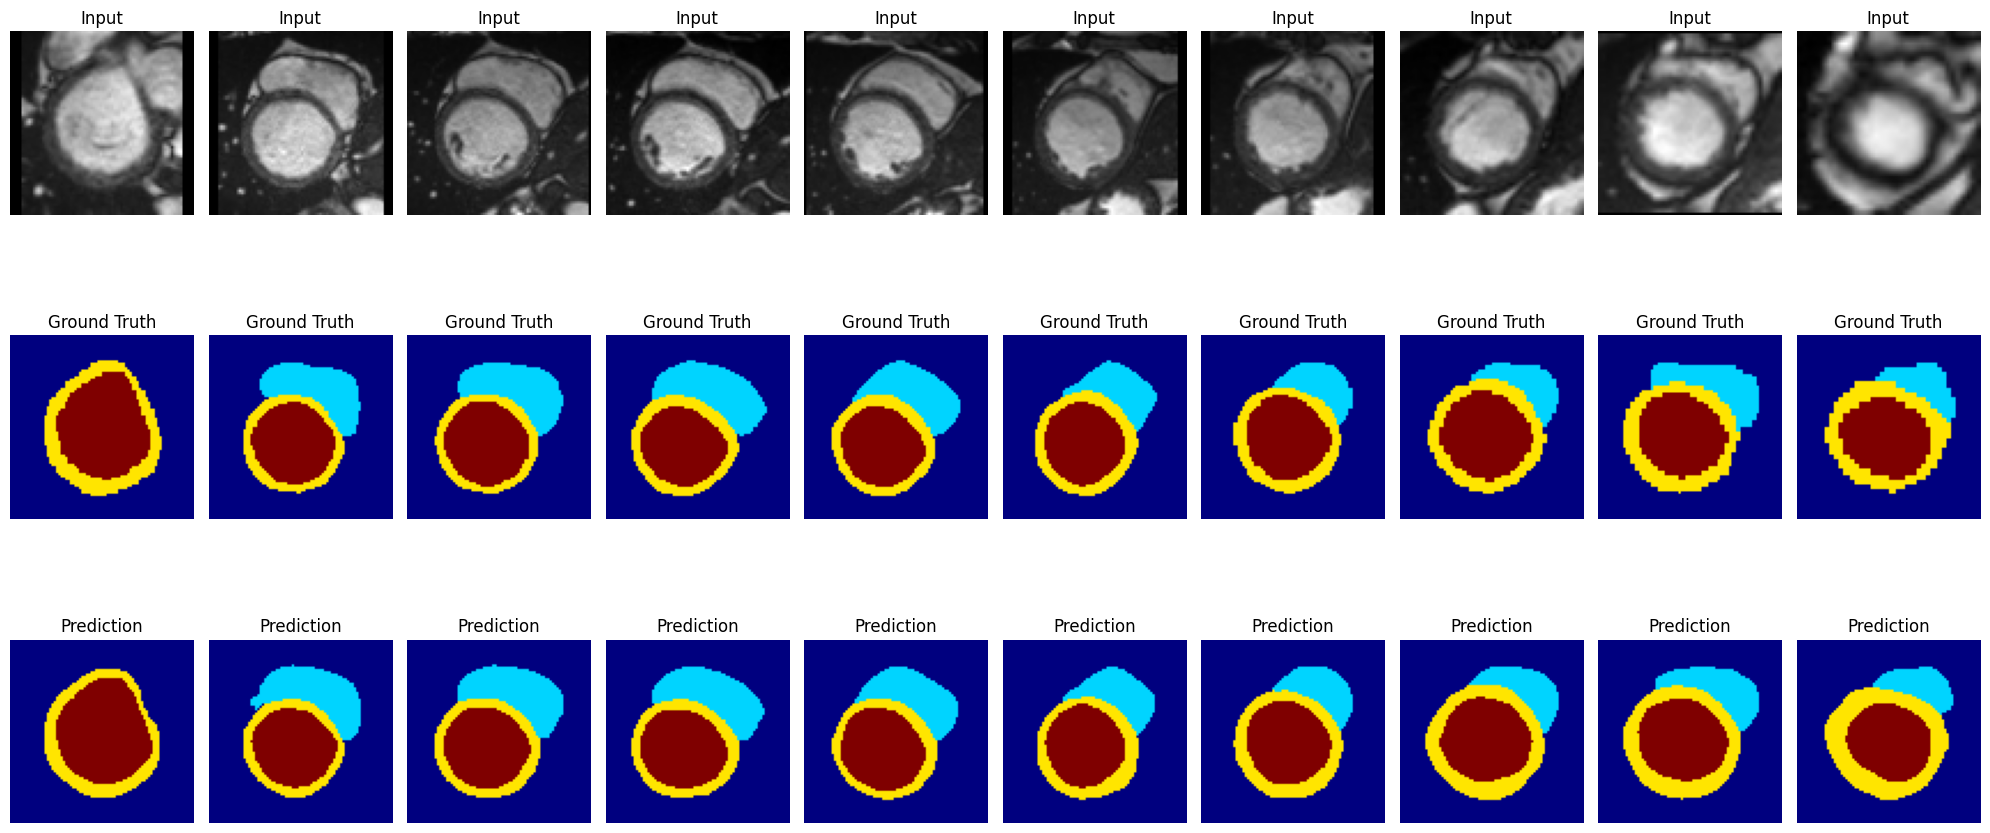

In [35]:
    # Evaluate on test set
    evaluate_model(model)

In [36]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculates the Dice coefficient."""
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)


In [37]:
def resize_to_original(predicted_mask_80x80x4xN, original_roi_slices):
    """
    Resizes a 4-channel predicted mask (80x80x4) for each of N slices
    back to the original ROI slice dimensions (which can vary), pads the
    resized images to 200x200, and converts the probability maps to
    discrete class labels.

    Args:
        predicted_mask_80x80x4xN (np.ndarray): The 4-channel predicted segmentation mask
                                                 of shape (N, 80, 80, 4).
        original_roi_slices (list or np.ndarray): A list or array of N slices, where each
                                                   slice is a 2D array representing the
                                                   original extracted ROI with shape
                                                   (original_roi_H_i, original_roi_W_i).

    Returns:
        np.ndarray: A NumPy array of shape (N, 200, 200), where each slice's
                    prediction has been resized to its original ROI dimensions,
                    padded to 200x200, and contains integer class labels.
    """
    num_slices_pred = predicted_mask_80x80x4xN.shape[0]
    num_slices_orig = len(original_roi_slices)

    if num_slices_pred != num_slices_orig:
        raise ValueError("Number of slices in predicted mask and original ROI slices must be the same.")

    padded_volume_labels = np.zeros((num_slices_pred, 512, 512), dtype=np.uint8)

    for i in range(num_slices_pred):
        original_h, original_w = original_roi_slices[i].shape[:2]
        resized_slice_channels = np.zeros((original_h, original_w, 4),
                                          dtype=predicted_mask_80x80x4xN.dtype)
        for channel in range(predicted_mask_80x80x4xN.shape[3]):
            predicted_slice_channel = predicted_mask_80x80x4xN[i, :, :, channel]
            resized_slice_channel = cv2.resize(predicted_slice_channel, (original_w, original_h),
                                                            interpolation=cv2.INTER_NEAREST)
            resized_slice_channels[:, :, channel] = resized_slice_channel

        # Convert probability maps to class labels
        resized_labels = np.argmax(resized_slice_channels, axis=-1).astype(np.uint8)

        # Calculate padding offsets
        pad_h = max(0, 512 - original_h)
        pad_w = max(0, 512 - original_w)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        # Pad the resized label mask
        padded_volume_labels[i] = np.pad(resized_labels,
                                         ((pad_top, pad_bottom), (pad_left, pad_right)),
                                         mode='constant', constant_values=0)

    return padded_volume_labels



In [40]:
def compute_bsa(weight_kg, height_cm):
    # DuBois formula
    return 0.007184 * (weight_kg**0.425) * (height_cm**0.725)


In [73]:
# def classify_acdc(edv_ml, ef, rv_edv_ml=None, rv_ef=None, bsa=None):
#     # Normalize LV volume
#     edv_norm = edv_ml / bsa if bsa else None

#     # MINF vs DCM: both EF<40%, distinguished by EDV_norm>100
#     if ef < 40:
#         if edv_norm and edv_norm > 100:
#             return 'DCM'
#         else:
#             return 'MINF'

#     # HCM: EF>55% but requires hypertrophy – assume EF>55 implies HCM if no thickness data
#     if ef > 55:
#         return 'HCM'

#     # NOR: EF>50% and not HCM
#     if ef > 50:
#         return 'NOR'

#     # Borderline EF (40–50%): ambiguous—could exclude or label 'UNCLASSIFIED'
#     if 40 <= ef <= 50:
#         return 'BORDERLINE'

#     # ARV: check right ventricle
#     if rv_edv_ml and bsa and (rv_edv_ml / bsa > 110) or (rv_ef and rv_ef < 40):
#         return 'ARV'

#     return 'UNCLASSIFIED'
def classify_acdc(edv_ml, ef, rv_edv_ml=None, rv_ef=None, bsa=None):
    """
    Assigns one of the five ACDC groups (NOR, MINF, DCM, HCM, ARV)
    or BORDERLINE/UNCLASSIFIED based on LV/RV volumes & EF.
    """

    # 1) Compute BSA‐indexed LV EDV (mL/m²)
    edv_i = edv_ml / bsa if bsa and bsa > 0 else None  # :contentReference[oaicite:0]{index=0}

    # 2) Hypertrophic cardiomyopathy: LV EF > 55%
    if ef > 55:
        return 'HCM'                                      # :contentReference[oaicite:1]{index=1}

    # 3) Systolic dysfunction (EF < 40%): split MINF vs DCM by LV dilation
    if ef < 40:
        if edv_i and edv_i > 100:                       # :contentReference[oaicite:2]{index=2}
            return 'DCM'                                # dilated ventricles :contentReference[oaicite:3]{index=3}
        else:
            return 'MINF'                               # post‐MI adaptation :contentReference[oaicite:4]{index=4}

    # 4) Abnormal right ventricle: RV dilation or low RV EF
    if rv_ef is not None and rv_ef < 40:                # :contentReference[oaicite:5]{index=5}
        return 'RV'
    rv_edv_i = rv_edv_ml / bsa if rv_edv_ml and bsa else None
    if rv_edv_i and rv_edv_i > 100:                    # :contentReference[oaicite:6]{index=6}
        return 'RV'

    # 5) Normal: preserved LV EF ≥ 50% and no other flags
    if ef >= 50:
        return 'NOR'

    # 6) Borderline EF 40–50%
    if 40 <= ef < 50:
        return 'BORDERLINE'

    return 'UNCLASSIFIED'



In [74]:
from logging import INFO
# def eval():
#     results = []

#     for i in range(101, 151):
#         patient_folder = os.path.join(testing_folder, f"patient{i:03d}")

#         # Load ED and ES data
#         ED_test_images, ED_test_masks, ED_roi_images, ED_roi_masks, ED_volume_info = load_patient_data(patient_folder , 'ED')
#         ES_test_images, ES_test_masks, ES_roi_images, ES_roi_masks, ES_volume_info = load_patient_data(patient_folder , 'ES')

#         # Extract ED/ES frame numbers from Info.cfg
#         info = extract_cfg_values(os.path.join(patient_folder, "Info.cfg"))

#         es = info.get('ES').zfill(2)
#         ed = info.get('ED').zfill(2)

#         weight, height = float(info['Weight']), float(info['Height'])
#         bsa = compute_bsa(weight, height)

#         #### ----------- Predict & Calculate ED Volumes -----------
#         ED_predicted = model.predict(ED_test_images)
#         ED_predicted_mask = np.argmax(ED_predicted, axis=-1).astype(np.uint8)
#         ED_predicted_mask = tf.keras.utils.to_categorical(ED_predicted_mask, num_classes=4)
#         ED_predicted_mask_resized = resize_to_original(ED_predicted_mask, ED_roi_masks)
#         ED_volume_predicted = calculate_volume(os.path.join(patient_folder, f"patient{i:03d}_frame{ed}.nii"), ED_predicted_mask_resized)

#         ED_gt_data, _ = load_nii_file(os.path.join(patient_folder, f"patient{i:03d}_frame{ed}_gt.nii"))
#         ED_volume = calculate_volume(os.path.join(patient_folder, f"patient{i:03d}_frame{ed}_gt.nii"), ED_gt_data)

#         #### ----------- Predict & Calculate ES Volumes -----------
#         ES_predicted = model.predict(ES_test_images)
#         ES_predicted_mask = np.argmax(ES_predicted, axis=-1).astype(np.uint8)
#         ES_predicted_mask = tf.keras.utils.to_categorical(ES_predicted_mask, num_classes=4)
#         ES_predicted_mask_resized = resize_to_original(ES_predicted_mask, ES_roi_masks)
#         ES_volume_predicted = calculate_volume(os.path.join(patient_folder, f"patient{i:03d}_frame{es}.nii"), ES_predicted_mask_resized)

#         ES_gt_data, _ = load_nii_file(os.path.join(patient_folder, f"patient{i:03d}_frame{es}_gt.nii"))
#         ES_volume = calculate_volume(os.path.join(patient_folder, f"patient{i:03d}_frame{es}_gt.nii"), ES_gt_data)

#         #### ----------- Compute SV and EF for LV (label = 3) -----------
#         EDV_pred_lv = ED_volume_predicted.get(3, 0)
#         ESV_pred_lv = ES_volume_predicted.get(3, 0)
#         SV_pred = EDV_pred_lv - ESV_pred_lv
#         EF_pred = (SV_pred / EDV_pred_lv) * 100 if EDV_pred_lv != 0 else 0

#         EDV_gt_lv = ED_volume.get(3, 0)
#         ESV_gt_lv = ES_volume.get(3, 0)
#         SV_gt = EDV_gt_lv - ESV_gt_lv
#         EF_gt = (SV_gt / EDV_gt_lv) * 100 if EDV_gt_lv != 0 else 0

#         category_pred = classify_acdc(EDV_pred_lv, EF_pred, bsa=bsa)
#         category_gt   = classify_acdc(EDV_gt_lv,   EF_gt,   bsa=bsa)


#         #### ----------- Store Results -----------
#         results.append({
#             "Patient": f"patient{i:03d}",
#             "EDV_pred": EDV_pred_lv,
#             "ESV_pred": ESV_pred_lv,
#             "SV_pred": SV_pred,
#             "EF_pred": EF_pred,
#             "EDV_gt": EDV_gt_lv,
#             "ESV_gt": ESV_gt_lv,
#             "SV_gt": SV_gt,
#             "EF_gt": EF_gt,
#             "Category_pred": category_pred,
#             "Category_gt":   category_gt,
#         })

#         #### ----------- Optional Console Output -----------
#         print(f"[Patient {i:03d}]")
#         print(f"Predicted   -> EDV: {EDV_pred_lv:.2f} ml, ESV: {ESV_pred_lv:.2f} ml, SV: {SV_pred:.2f} ml, EF: {EF_pred:.2f}%")
#         print(f"Ground Truth-> EDV: {EDV_gt_lv:.2f} ml, ESV: {ESV_gt_lv:.2f} ml, SV: {SV_gt:.2f} ml, EF: {EF_gt:.2f}%\n")

#     #### ----------- Save Results to CSV -----------
#     df = pd.DataFrame(results)
#     df.to_csv("cardiac_volume_results.csv", index=False)
#     print("Saved results to cardiac_volume_results.csv")
def eval():
    results = []
    for pid in range(101, 151):
        folder = os.path.join(testing_folder, f"patient{pid:03d}")
        info = extract_cfg_values(os.path.join(folder, "Info.cfg"))
        weight, height = float(info['Weight']), float(info['Height'])
        bsa = compute_bsa(weight, height)  # m²

        # --- Load & predict phases ---
        def load_and_predict(phase):
            imgs, _, _, roi_masks, _ = load_patient_data(folder, phase)
            preds = model.predict(imgs)
            lbls = np.argmax(preds, axis=-1).astype(np.uint8)
            cat  = tf.keras.utils.to_categorical(lbls, num_classes=4)
            return resize_to_original(cat, roi_masks), lbls

        # ED phase
        ED_mask_resized, ED_lbls = load_and_predict('ED')
        # ES phase
        ES_mask_resized, ES_lbls = load_and_predict('ES')

        # Paths for volumes
        ed_path    = os.path.join(folder, f"patient{pid:03d}_frame{info['ED'].zfill(2)}.nii")
        es_path    = os.path.join(folder, f"patient{pid:03d}_frame{info['ES'].zfill(2)}.nii")
        ed_gt_path = ed_path.replace('.nii', '_gt.nii')
        es_gt_path = es_path.replace('.nii', '_gt.nii')

        # --- Calculate volumes dicts {label: mL} ---
        ED_pred_vol = calculate_volume(ed_path, ED_mask_resized)
        ES_pred_vol = calculate_volume(es_path, ES_mask_resized)
        ED_gt_vol   = calculate_volume(ed_gt_path, load_nii_file(ed_gt_path)[0])
        ES_gt_vol   = calculate_volume(es_gt_path, load_nii_file(es_gt_path)[0])

        # --- Derive metrics ---
        # LV
        edv_pred = ED_pred_vol.get(3, 0); edv_gt = ED_gt_vol.get(3, 0)
        esv_pred = ES_pred_vol.get(3, 0); esv_gt = ES_gt_vol.get(3, 0)
        sv_pred  = edv_pred - esv_pred;     sv_gt  = edv_gt - esv_gt
        ef_pred  = (sv_pred / edv_pred * 100) if edv_pred else 0
        ef_gt    = (sv_gt   / edv_gt   * 100) if edv_gt   else 0

        # RV
        rv_edv_pred = ED_pred_vol.get(1, 0);   rv_esv_pred = ES_pred_vol.get(1, 0)
        rv_sv_pred  = rv_edv_pred - rv_esv_pred
        rv_ef_pred  = (rv_sv_pred / rv_edv_pred * 100) if rv_edv_pred else 0

        # --- Classify ---
        cat_pred = classify_acdc(edv_pred, ef_pred,
                                 rv_edv_ml=rv_edv_pred, rv_ef=rv_ef_pred, bsa=bsa)
        cat_gt   = info['Group']
        # --- Store ---
        results.append({
            "Patient":      f"patient{pid:03d}",
            "EDV_pred":     edv_pred, "ESV_pred": esv_pred,
            "SV_pred":      sv_pred, "EF_pred": ef_pred,
            "RV_EDV_pred":  rv_edv_pred, "RV_EF_pred": rv_ef_pred,
            "EDV_gt":       edv_gt,   "ESV_gt":   esv_gt,
            "SV_gt":        sv_gt,    "EF_gt":    ef_gt,
            "RV_EDV_gt":    ED_gt_vol.get(1,0),
            "RV_EF_gt":     ( (ED_gt_vol.get(1,0)-ES_gt_vol.get(1,0))
                              / ED_gt_vol.get(1,1e-9) *100 ),
            "Category_pred": cat_pred,
            "Category_gt":   cat_gt
        })

    # Save aggregated results
    pd.DataFrame(results).to_csv("acdc_full_metrics.csv", index=False)
    print("Saved acdc_full_metrics.csv")


In [75]:
eval()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [76]:
def evaluate_results(csv_path):
    """
    Reads the ACDC metrics CSV and prints:
      - Overall subgroup accuracy
      - Classification report (precision, recall, F1)
      - Confusion matrix
      - Mean Absolute Error for EDV, ESV, SV, EF
    """
    # 1) Load data
    df = pd.read_csv(csv_path)   # :contentReference[oaicite:10]{index=10}

    # 2) Extract true vs. predicted labels
    y_true = df['Category_gt']
    y_pred = df['Category_pred']

    # 3) Classification metrics
    acc = accuracy_score(y_true, y_pred)  # :contentReference[oaicite:11]{index=11}
    print(f"Overall Classification Accuracy: {acc*100:.2f}%\n")

    labels = sorted(df['Category_gt'].unique())
    print("Classification Report:")
    print(classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=labels,
        digits=3                 # three decimal places            :contentReference[oaicite:12]{index=12}
    ))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred, labels=labels)   # :contentReference[oaicite:13]{index=13}
    print(pd.DataFrame(cm, index=labels, columns=labels), "\n")

    # 4) Regression errors for quantitative metrics
    numeric_metrics = ['EDV_pred','EDV_gt','ESV_pred','ESV_gt',
                       'SV_pred','SV_gt','EF_pred','EF_gt']
    print("Mean Absolute Errors:")
    for met in ['EDV','ESV','SV','EF']:
        mae = mean_absolute_error(
            df[f"{met}_gt"], df[f"{met}_pred"]
        )  # :contentReference[oaicite:14]{index=14}
        print(f"  {met}: {mae:.2f} (units)")

    # 5) Optionally, return the DataFrame for further analysis
    return df


In [77]:
evaluate_results("acdc_full_metrics.csv")

Overall Classification Accuracy: 58.00%

Classification Report:
              precision    recall  f1-score   support

         DCM      0.818     0.900     0.857        10
         HCM      0.370     1.000     0.541        10
        MINF      1.000     0.700     0.824        10
         NOR      0.000     0.000     0.000        10
          RV      1.000     0.300     0.462        10

   micro avg      0.604     0.580     0.592        50
   macro avg      0.638     0.580     0.537        50
weighted avg      0.638     0.580     0.537        50

Confusion Matrix:
      DCM  HCM  MINF  NOR  RV
DCM     9    0     0    0   0
HCM     0   10     0    0   0
MINF    2    0     7    0   0
NOR     0   10     0    0   0
RV      0    7     0    0   3 

Mean Absolute Errors:
  EDV: 24.46 (units)
  ESV: 13.02 (units)
  SV: 11.97 (units)
  EF: 2.17 (units)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Patient,EDV_pred,ESV_pred,SV_pred,EF_pred,RV_EDV_pred,RV_EF_pred,EDV_gt,ESV_gt,SV_gt,EF_gt,RV_EDV_gt,RV_EF_gt,Category_pred,Category_gt
0,patient101,210.970272,147.986037,62.984235,29.854555,122.846175,46.384750,222.598131,156.007106,66.591025,29.915357,129.790591,46.018250,DCM,DCM
1,patient102,68.334961,19.848633,48.486328,70.953912,103.710938,39.736347,79.443359,23.144531,56.298828,70.866626,100.097656,50.243902,HCM,NOR
2,patient103,160.180664,119.287109,40.893555,25.529645,77.734375,59.861809,178.173828,131.762695,46.411133,26.048232,88.891602,61.603955,MINF,MINF
3,patient104,120.489182,17.850941,102.638240,85.184611,122.208853,71.566228,141.667314,22.037969,119.629346,84.443858,135.349389,65.571054,HCM,HCM
4,patient105,113.386142,24.259258,89.126884,78.604742,98.469232,55.292012,126.077634,25.889762,100.187871,79.465222,115.457323,60.190840,HCM,HCM
5,patient106,262.231445,237.719727,24.511719,9.347361,302.514648,11.500282,284.277344,262.768555,21.508789,7.566128,307.348633,11.621257,DCM,DCM
6,patient107,116.246078,46.337679,69.908399,60.138286,107.086956,30.912899,129.928685,50.487322,79.441362,61.142282,134.676474,40.097155,HCM,NOR
7,patient108,151.171875,23.144531,128.027344,84.689922,175.439453,68.480379,168.310547,27.050781,141.259766,83.928053,190.991211,65.703694,HCM,HCM
8,patient109,127.343750,63.085938,64.257812,50.460123,186.499023,25.893442,158.813477,75.634766,83.178711,52.375096,219.580078,33.744719,RV,RV
9,patient110,119.506836,38.452148,81.054688,67.824311,158.837891,43.728866,125.512695,41.748047,83.764648,66.737989,172.412109,45.213820,HCM,NOR


In [62]:
folder = os.path.join(training_folder, f"patient001")
info = extract_cfg_values(os.path.join(folder, "Info.cfg"))
print(info)

{'ED': '1', 'ES': '12', 'Group': 'DCM', 'Height': '184.0', 'NbFrame': '30', 'Weight': '95.0'}
